In [1]:
import numpy as np
import pandas as pd
import pickle

#img show and plotting
import matplotlib.pyplot as plt
import seaborn as sns

#image functions
from ImageFunctions import get_color_description, plot_color_hist, show_image, load_image, show_save_image
from ImageFunctions import show_images, get_categories_top_bottom_imgs, get_sorted_distances_list, remove_bottom_imgs
from ImageFunctions import get_bottleneck_features

# color distributions
import cv2

# class imbalance
import random

# splitting
from sklearn.model_selection import train_test_split

# vgg model
from keras.models import Model
from keras.applications import vgg16
import keras

# img augmentation
from skimage import exposure, transform
from skimage.util import random_noise

### Load Data

In [2]:
#data saved to local drive
X = np.load('/Users/racheldilley/Documents/lets-take-a-trip-data/X2.npy')
df = pd.read_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y2.pkl')

print(X.shape, df.shape) #check for same length

(74698, 150, 150, 3) (74698, 4)


In [3]:
df['category'].value_counts()

parks            22719
landmarks        11030
entertainment    10507
museums           9441
beaches/ocean     8498
gardens/zoo       7468
art               3121
sports            1914
Name: category, dtype: int64

Reset index of df to mastch index numbers of X

In [4]:
df.reset_index(inplace=True)
df.drop(['index'], 1, inplace=True)
df.tail(2)

,name,location,category,url
74696,Antler Arches of Jackson,"US Highway 26, Jackson, WY 83001",landmarks,https://media-cdn.tripadvisor.com/media/photo-...
74697,Antler Arches of Jackson,"US Highway 26, Jackson, WY 83001",landmarks,https://media-cdn.tripadvisor.com/media/photo-...


### Get list of color features for each image and add to df

- Split up image into center elipse and 4 corners of image
- Find R,G, and B color distributions with specified number of bins for each image

In [5]:
bins = [8,8,8]
color = cv2.COLOR_BGR2HSV
#BGR2RGB

#get color feats and add to df
color_feats = []
for x in X:
    color_feats.append(get_color_description(x, bins, color))

np.array(color_feats).shape

(74698, 4096)

In [6]:
df['color_feats'] = color_feats
df.info()

del color_feats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74698 entries, 0 to 74697
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         74698 non-null  object
 1   location     74646 non-null  object
 2   category     74698 non-null  object
 3   url          74698 non-null  object
 4   color_feats  74698 non-null  object
dtypes: object(5)
memory usage: 2.8+ MB


### Get vgg-16 features for each image

In [ ]:
# create vgg model
inputs = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=inputs)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

#dont want model weights to change durring training
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# get vgg features for all imgs and add to df
feats_arr = get_bottleneck_features(vgg_model, X)

df.info()

In [ ]:
feats_lists = []
for x in feats_arr:
    feats_lists.append(x)

len(feats_lists)

In [ ]:
df['vgg_feats'] = feats_lists

del feats_arr, feats_lists

df.info()

##### Get examples of color distributions and graphs for presentation

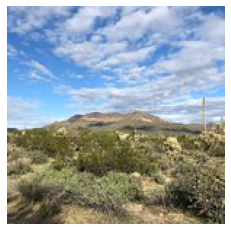

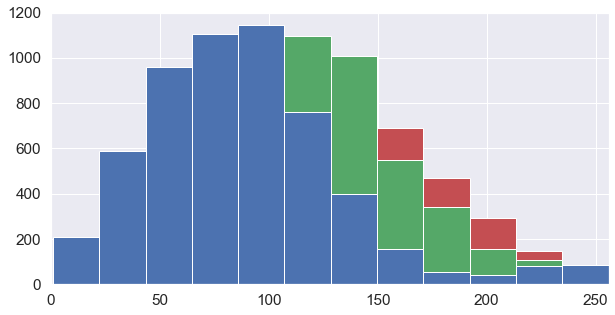

In [29]:
idx = 3457
url = df.loc[idx, 'url']

# load, show and save img
img = load_image(url)
show_save_image(img, 'color_feats')

# grab the dimensions and compute the center of the image
(h, w) = img.shape[:2]
(cX, cY) = (int(w * 0.5), int(h * 0.5))

# divide the image into four rectangles/segments (top-left, top-right, bottom-right, bottom-left)
segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]

rect = []
# loop over the segments
for (startX, endX, startY, endY) in segments:
    # construct a mask for each corner of the image, subtracting the elliptical center from it
    cornerMask = np.zeros(img.shape[:2], dtype = "uint8")
    rect.append((cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 1, -1))) #*img))

# get color distributions for top-right of image
bins = 12
mask = rect[2]
plot_color_hist(img, bins, mask, None)

## Find mislabeled images in each category and remove

### Investigate color distributions 

- Calculate the centroid of color distributions for each category
- Find closest and furthest images from centriod to show and investigate
- Remove furthest images and other specified indexes

In [37]:
categories = ['museums', 'parks','beaches/ocean', 'gardens/zoo', 'landmarks',  'art', 'entertainment', 'sports']

firstimgs, lastimgs = get_categories_top_bottom_imgs(df, categories, 10)

for key,value in lastimgs.items():
    show_images(X[value], key)

NameError: name 'X' is not defined

In [31]:
for key,value in firstimgs.items():
    show_images(X[value], key)

In [32]:
# remove furthest imgs
remove = []
X_cleaned, df_cleaned = remove_bottom_imgs(X, df, categories, lastimgs, remove)
print(X_cleaned.shape, df_cleaned.shape)

# clear up memory
# del X
# del df

(74618, 150, 150, 3) (74618, 6)


## Handling Class Imbalance

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


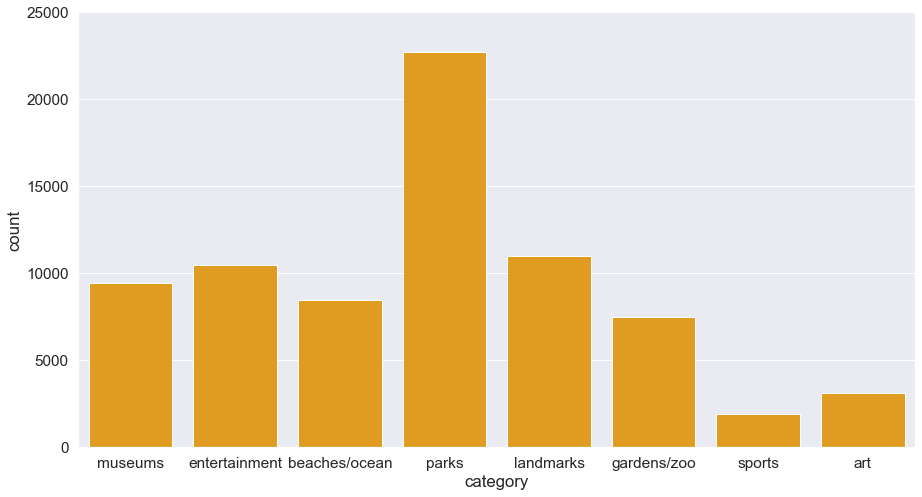

In [33]:
# investigate class imbalance
plt.rcParams['figure.figsize']=(15,8)
sns.set(font_scale = 1.4)
sns.countplot(df_cleaned['category'], palette=['orange'])
plt.ylim((0,25000))

plt.savefig('../Graphs/imbalanced.png')

Combine Sports and Entertainemnt and Art and Museums

In [36]:
df_cleaned_classes = df_cleaned.copy()
df_cleaned_classes = df_cleaned_classes.reset_index()
X_cleaned_classes = X_cleaned.copy()

# replace sports and art classes
df_cleaned_classes['category'] = df_cleaned_classes['category'].str.replace('sports','entertainment')
df_cleaned_classes['category'] = df_cleaned_classes['category'].str.replace('art','museums')

# save each category as pickle
new_cats = ['museums', 'parks','beaches/ocean', 'gardens/zoo', 'landmarks', 'entertainment']
new_cats_name = ['museums', 'parks','beaches_ocean', 'gardens_zoo', 'landmarks', 'entertainment']
grouped = df_cleaned_classes.groupby('category')
for idx, cat in enumerate(new_cats):
    group = pd.DataFrame(grouped.get_group(cat)).reset_index()
    group.drop(['category', 'level_0', 'index'], axis = 1, inplace=True)
    mid = len(group) // 2
    letter = ['A', 'B']
    for x in letter:
        local_path ='/Users/racheldilley/Documents/lets-take-a-trip-data/AppData/' + new_cats_name[idx] + '_' + x + '_df.pkl'
        if x == 'A':
            half_df = group[:mid]
        else:
            half_df = group[mid:]
        print(cat, len(half_df))
#         half_df.to_pickle(local_path)

#clear up memory
# del df_cleaned
# del X_cleaned

# check for class removal
sns.set(font_scale = 1.7)
sns.countplot(df_cleaned_classes['category'], palette=['orange'])
plt.ylim((0,25000))

plt.savefig('../Graphs/class_removal.png')

### Undersampling

In [35]:
# find difference between museum and parks classes to find number of images to remove
museum_len = len(grouped.get_group('museums'))
parks_len = len(grouped.get_group('parks'))
num_to_remove = parks_len - museum_len

# get list of parks indexes and randomly sample
parks_indexes = grouped.get_group('parks').index.tolist()
indexes_to_remove =  random.sample(parks_indexes, num_to_remove)
print(num_to_remove, len(indexes_to_remove))

# drop indexes from df and X images
df_cleaned_classes.drop(df_cleaned_classes.index[indexes_to_remove], inplace = True)
X_cleaned_classes = np.delete(X_cleaned_classes, indexes_to_remove, 0)
print(len(df_cleaned_classes), len(X_cleaned_classes))

del grouped
del indexes_to_remove

10167 10167
64451 64451


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


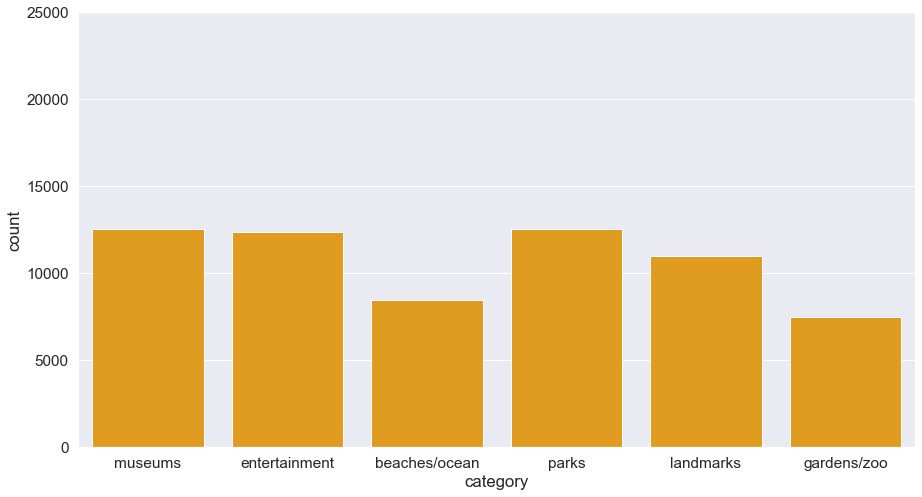

In [36]:
# check for class balance
sns.countplot(df_cleaned_classes['category'], palette=['orange'])
plt.ylim((0,25000))

plt.savefig('../Graphs/undersampling.png')

### Image Augmentation

##### Image augmentation example for presentation

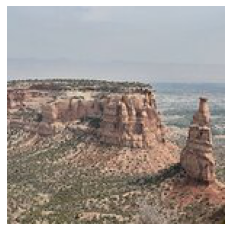

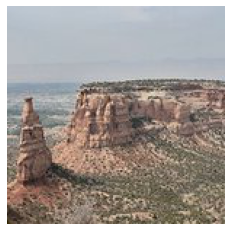

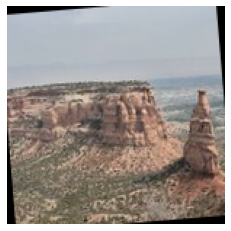

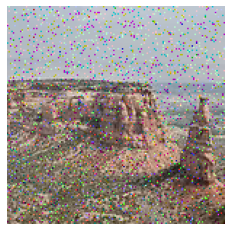

In [37]:
# load and save img
url = df_cleaned_classes.loc[6790, 'url']
img = load_image(url)
show_save_image(img, 'regular')

# augment img and save
horiz = np.fliplr(img)
show_save_image(horiz, 'flipped')
trans = transform.rotate(img, random.uniform(-30,30))
show_save_image(trans, 'transformed')
noise = random_noise(img, mode='s&p', clip=True)
show_save_image(noise, 'noise')

### Split data into train, test, and validation sets

In [39]:
y = df_cleaned_classes['category']
del df_cleaned_classes

# create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_classes, y, test_size=0.2)

del y
del X_cleaned_classes

# create training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(38670, 150, 150, 3) (12890, 150, 150, 3) (12891, 150, 150, 3)
(38670,) (12890,) (12891,)


### Pickle and save cleaned data locally

In [41]:
# save cleaned X
np.savez_compressed('/Users/racheldilley/Documents/lets-take-a-trip-data/X_train_clean.npz',X_train)
# del X_train
np.savez_compressed('/Users/racheldilley/Documents/lets-take-a-trip-data/X_test_clean.npz',X_test)
# del X_test
np.savez_compressed('/Users/racheldilley/Documents/lets-take-a-trip-data/X_val_clean.npz',X_val)
# del X_val

# save cleaned Y locally
# y_train.to_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y_train_clean.pkl')
# y_test.to_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y_test_clean.pkl')
# y_val.to_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y_val_clean.pkl')

# svaing locally for google cloud platform
y_train.to_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y_train_clean.pkl', protocol=2)
y_test.to_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y_test_clean.pkl', protocol=2)
y_val.to_pickle( '/Users/racheldilley/Documents/lets-take-a-trip-data/Y_val_clean.pkl', protocol=2)
